In [1]:
# FIX FOR RTX 5080 / CUDA 12 HARDWARE
# This cell patches the environment to ensure TensorFlow finds the GPU correctly
import os
import sys
import ctypes

def preload_nvidia_libs():
    try:
        # Attempt to locate site-packages content
        paths_to_check = []
        if hasattr(sys, 'prefix'):
            paths_to_check.append(os.path.join(sys.prefix, "lib", f"python{sys.version_info.major}.{sys.version_info.minor}", "site-packages", "nvidia"))
        
        nvidia_base = None
        for p in paths_to_check:
            if os.path.exists(p):
                nvidia_base = p
                break
        
        if not nvidia_base:
            print("Could not find nvidia packages to preload. GPU might not be detected.")
            return

        libs_to_load = [
            ("cudnn/lib", "libcudnn.so.9"),
            ("cublas/lib", "libcublas.so.12"),
            ("cublas/lib", "libcublasLt.so.12"),
            ("cufft/lib", "libcufft.so.11"),
            ("curand/lib", "libcurand.so.10"),
            ("cusolver/lib", "libcusolver.so.11"),
            ("cusparse/lib", "libcusparse.so.12"),
            ("nccl/lib", "libnccl.so.2"),
        ]
        
        print(f"Preloading NVIDIA libraries from {nvidia_base}...")
        for subdir, libname in libs_to_load:
            path = os.path.join(nvidia_base, subdir, libname)
            if os.path.exists(path):
                try:
                    ctypes.CDLL(path)
                except Exception as e:
                    print(f"Warning: Failed to load {libname}: {e}")
        print("NVIDIA libraries preloaded.")
    except Exception as e:
        print(f"Error during preload: {e}")

preload_nvidia_libs()


Preloading NVIDIA libraries from /home/fabit/brain-tumor-detection/.venv/lib/python3.12/site-packages/nvidia...
NVIDIA libraries preloaded.


# TASK #2: IMPORT LIBRARIES AND DATASETS

In [2]:
# Configuration and paths
import os
from pathlib import Path

# Set base directory
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models'

# Ensure directories exist
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

# Configuration constants
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
IMAGE_SIZE = (256, 256)
EPOCHS = 100

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score,RocCurveDisplay, precision_score, f1_score
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import random
%matplotlib inline

I0000 00:00:1765236670.136144   10436 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765236670.177646   10436 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1765236670.877959   10436 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Google Colab code removed - running locally
# Data should be in the 'data' directory relative to the notebook

In [4]:
# Google Colab directory change removed - running locally
# Working directory is already set to the project root


In [5]:
# Load data from data directory
brain_df = pd.read_csv(DATA_DIR / 'route_label.csv', index_col=0)

In [6]:
# Custom Callback that forces printing to stdout to ensure visibility
from tensorflow.keras.callbacks import Callback

class ForceProgressPrint(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f'\n🚀 Starting Epoch {epoch + 1}...')

    def on_train_batch_end(self, batch, logs=None):
        if batch % 10 == 0:  # Print every 10 batches
            loss = logs.get('loss', 0)
            acc = logs.get('accuracy', 0)
            print(f'   Batch {batch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}')


# DATA

In [7]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.to_csv(DATA_DIR / "segmentation_routes_labels.csv")
brain_df_mask.shape

(1366, 3)

In [8]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

brain_df_mask_train, brain_df_mask_val = train_test_split(brain_df_mask, test_size=0.2,random_state=42)
brain_df_mask_test, brain_df_mask_val = train_test_split(brain_df_mask_val, test_size=0.5,random_state=42)

In [9]:
# Save train/test/val splits to data directory
brain_df_mask_train.to_csv(DATA_DIR / "segmentation_train.csv")
brain_df_mask_test.to_csv(DATA_DIR / "segmentation_test.csv")
brain_df_mask_val.to_csv(DATA_DIR / "segmentation_validation.csv")

In [10]:
BATCH_SIZE = 16

In [11]:
# Seed for synchronizing image and mask augmentations
SEED = 42

# Generator WITH augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator WITHOUT augmentation for validation/test
val_datagen = ImageDataGenerator(rescale=1./255.)

In [12]:
def train_generator_fn():
    """Training generator with synchronized augmentation for image and mask."""
    image_generator = train_datagen.flow_from_dataframe(
        brain_df_mask_train,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,  # Same seed for synchronization
        shuffle=True
    )

    mask_generator = train_datagen.flow_from_dataframe(
        brain_df_mask_train,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,  # Same seed - ensures identical transformations
        shuffle=True
    )

    while True:
        img = next(image_generator)
        msk = next(mask_generator)
        # Binarize masks (augmentation can create intermediate values)
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

training_generator = train_generator_fn()


def val_generator_fn():
    """Validation generator WITHOUT augmentation."""
    image_generator_val = val_datagen.flow_from_dataframe(
        brain_df_mask_val,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False  # No shuffle for validation
    )

    mask_generator_val = val_datagen.flow_from_dataframe(
        brain_df_mask_val,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False
    )

    while True:
        img = next(image_generator_val)
        msk = next(mask_generator_val)
        # Binarize masks
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

validation_generator = val_generator_fn()


In [13]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [14]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [15]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


W0000 00:00:1765236671.226114   10436 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765236671.226453   10436 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765236671.226721   10436 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765236671.226733   10436 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1765236671.229105   10436 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not us

In [16]:
model_seg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d_1[

 Total params: 1,210,513 (4.62 MB)

 Trainable params: 1,206,129 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

In [17]:
LEARNING_RATE = 1e-4
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

model_seg.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss=bce_dice_loss,
              metrics=[dice_coef, iou_coef, 'accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(str(MODELS_DIR / "segmentation_ResUNet6.keras"), save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

steps_per_epoch_calc = len(brain_df_mask_train) // BATCH_SIZE
validation_steps_calc = len(brain_df_mask_val) // BATCH_SIZE

history = model_seg.fit(
    training_generator, # Use the direct Python generator
    steps_per_epoch=steps_per_epoch_calc,
    epochs=EPOCHS,
    validation_data=validation_generator, # Use the direct Python generator
    validation_steps=validation_steps_calc,
    callbacks=callbacks)


Found 1092 validated image filenames.
Found 1092 validated image filenames.
Epoch 1/100


I0000 00:00:1765236677.801380   10591 service.cc:153] XLA service 0x7991c006fbd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765236677.801419   10591 service.cc:161]   StreamExecutor device (0): NVIDIA GeForce RTX 5080, Compute Capability 12.0a
I0000 00:00:1765236677.948892   10591 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765236679.056752   10591 cuda_dnn.cc:461] Loaded cuDNN version 91700
I0000 00:00:1765236684.908628   10756 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_9', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1765236689.706472   10591 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_9', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1765236689.742474   10591 device_compil

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4278 - dice_coef: 0.0755 - iou_coef: 0.0393 - loss: 1.6993Found 137 validated image filenames.
Found 137 validated image filenames.

Epoch 1: val_loss improved from None to 1.72184, saving model to /home/fabit/brain-tumor-detection/notebooks/models/segmentation_ResUNet6.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 116ms/step - accuracy: 0.5817 - dice_coef: 0.0852 - iou_coef: 0.0446 - loss: 1.5651 - val_accuracy: 0.1966 - val_dice_coef: 0.0687 - val_iou_coef: 0.0356 - val_loss: 1.7218 - learning_rate: 1.0000e-04
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9140 - dice_coef: 0.1054 - iou_coef: 0.0559 - loss: 1.3424
Epoch 2: val_loss improved from 1.72184 to 1.65862, saving model to /home/fabit/brain-tumor-detection/notebooks/models/segmentation_ResUNet6.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.9352 - dice_coef: 0.1219 - iou_coef: 0.0651 - loss: 1.2920 - val_accuracy: 0.4122 - val_dice_coef: 0.0762 - va

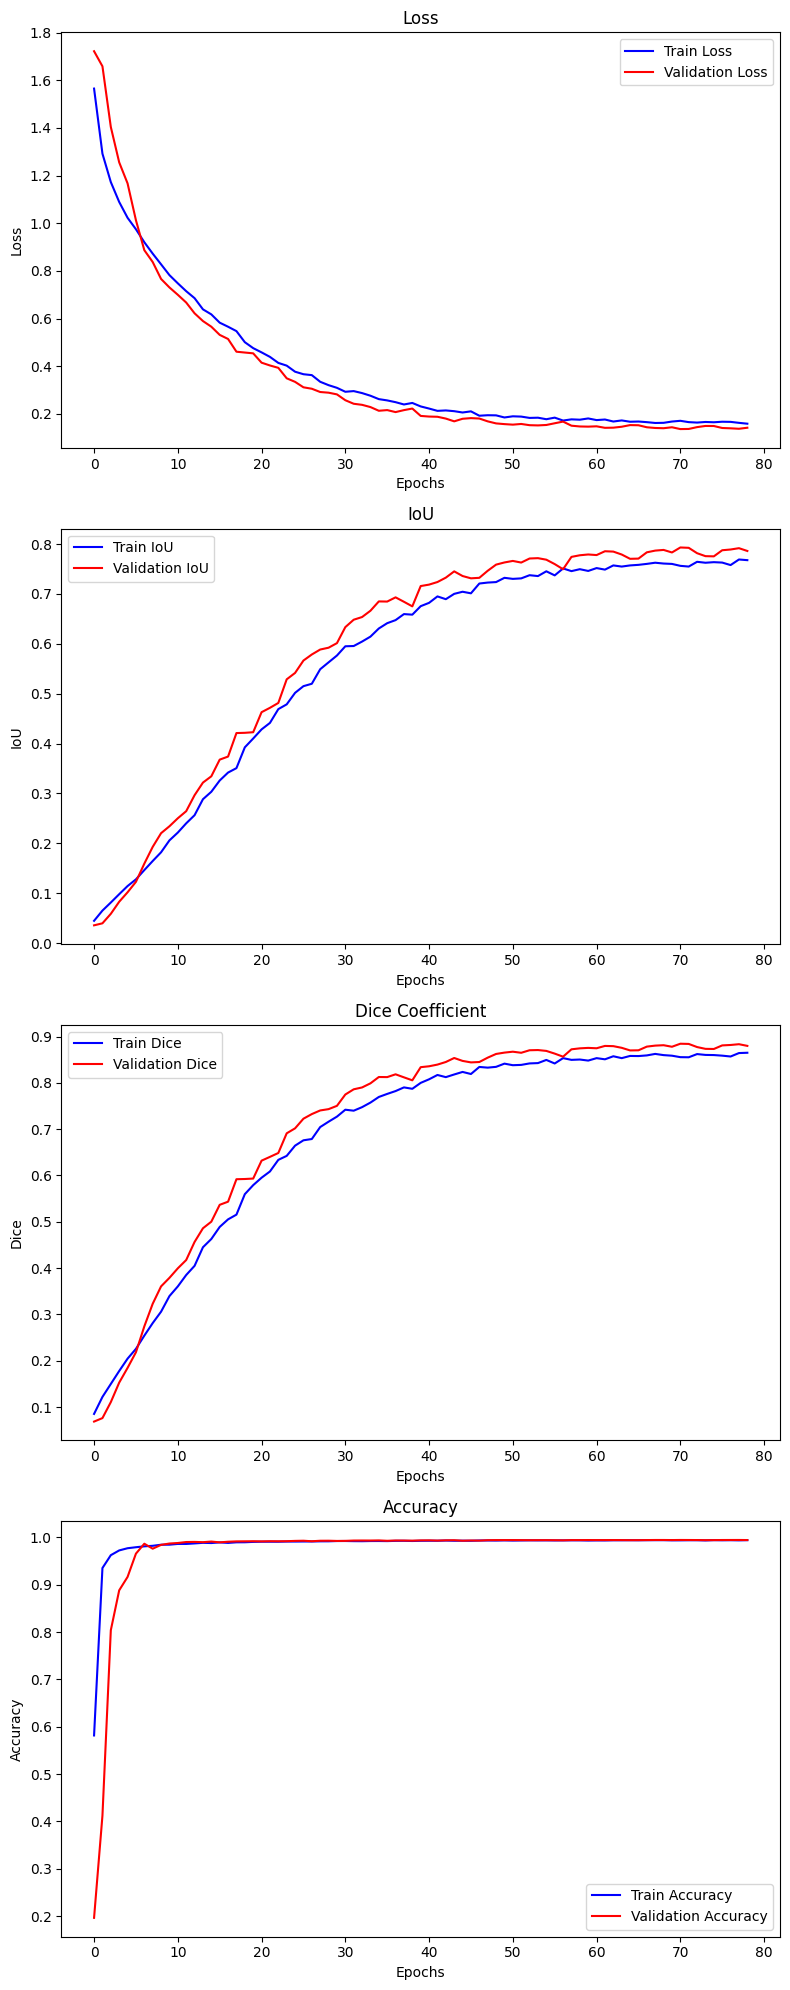

In [18]:
# Evaluation Visualization
plt.figure(figsize=(8, 20))

# --- Loss ---
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.legend(loc='best')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# --- IoU ---
plt.subplot(4, 1, 2)
plt.plot(history.history['iou_coef'], 'b-', label='Train IoU')
plt.plot(history.history['val_iou_coef'], 'r-', label='Validation IoU')
plt.legend(loc='best')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')

# --- Dice Coefficient ---
plt.subplot(4, 1, 3)
plt.plot(history.history['dice_coef'], 'b-', label='Train Dice')
plt.plot(history.history['val_dice_coef'], 'r-', label='Validation Dice')
plt.legend(loc='best')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice')

plt.subplot(4, 1, 4)
plt.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [19]:
loaded_model_seg=load_model(str(MODELS_DIR / "segmentation_ResUNet6.keras"), custom_objects={"bce_dice_loss":bce_dice_loss, "dice_coef":dice_coef, "iou_coef":iou_coef})

In [20]:
def test_generator_fn():
    """Test generator WITHOUT augmentation - uses val_datagen."""
    image_generator_test = val_datagen.flow_from_dataframe(
        brain_df_mask_test,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False  # No shuffle for test
    )

    mask_generator_test = val_datagen.flow_from_dataframe(
        brain_df_mask_test,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False
    )

    while True:
        img = next(image_generator_test)
        msk = next(mask_generator_test)
        # Binarize masks
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

test_generator = test_generator_fn()


In [21]:

loaded_model_seg=load_model(str(MODELS_DIR / "segmentation_ResUNet6.keras"), custom_objects={"bce_dice_loss":bce_dice_loss, "dice_coef":dice_coef, "iou_coef":iou_coef})
prediction_seg = loaded_model_seg.evaluate(test_generator, steps=len(brain_df_mask_test) // BATCH_SIZE, verbose=1)

Found 137 validated image filenames.
Found 137 validated image filenames.
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9922 - dice_coef: 0.8394 - iou_coef: 0.7239 - loss: 0.1914


In [22]:
print(f" Test Accuracy: {prediction_seg[3]:.4f}")
print(f" Test Dice Coefficient: {prediction_seg[1]:.4f}")
print(f" Test IoU: {prediction_seg[2]:.4f}")
print(f" Test Loss: {prediction_seg[0]:.4f}")

 Test Accuracy: 0.9922
 Test Dice Coefficient: 0.8394
 Test IoU: 0.7239
 Test Loss: 0.1914


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


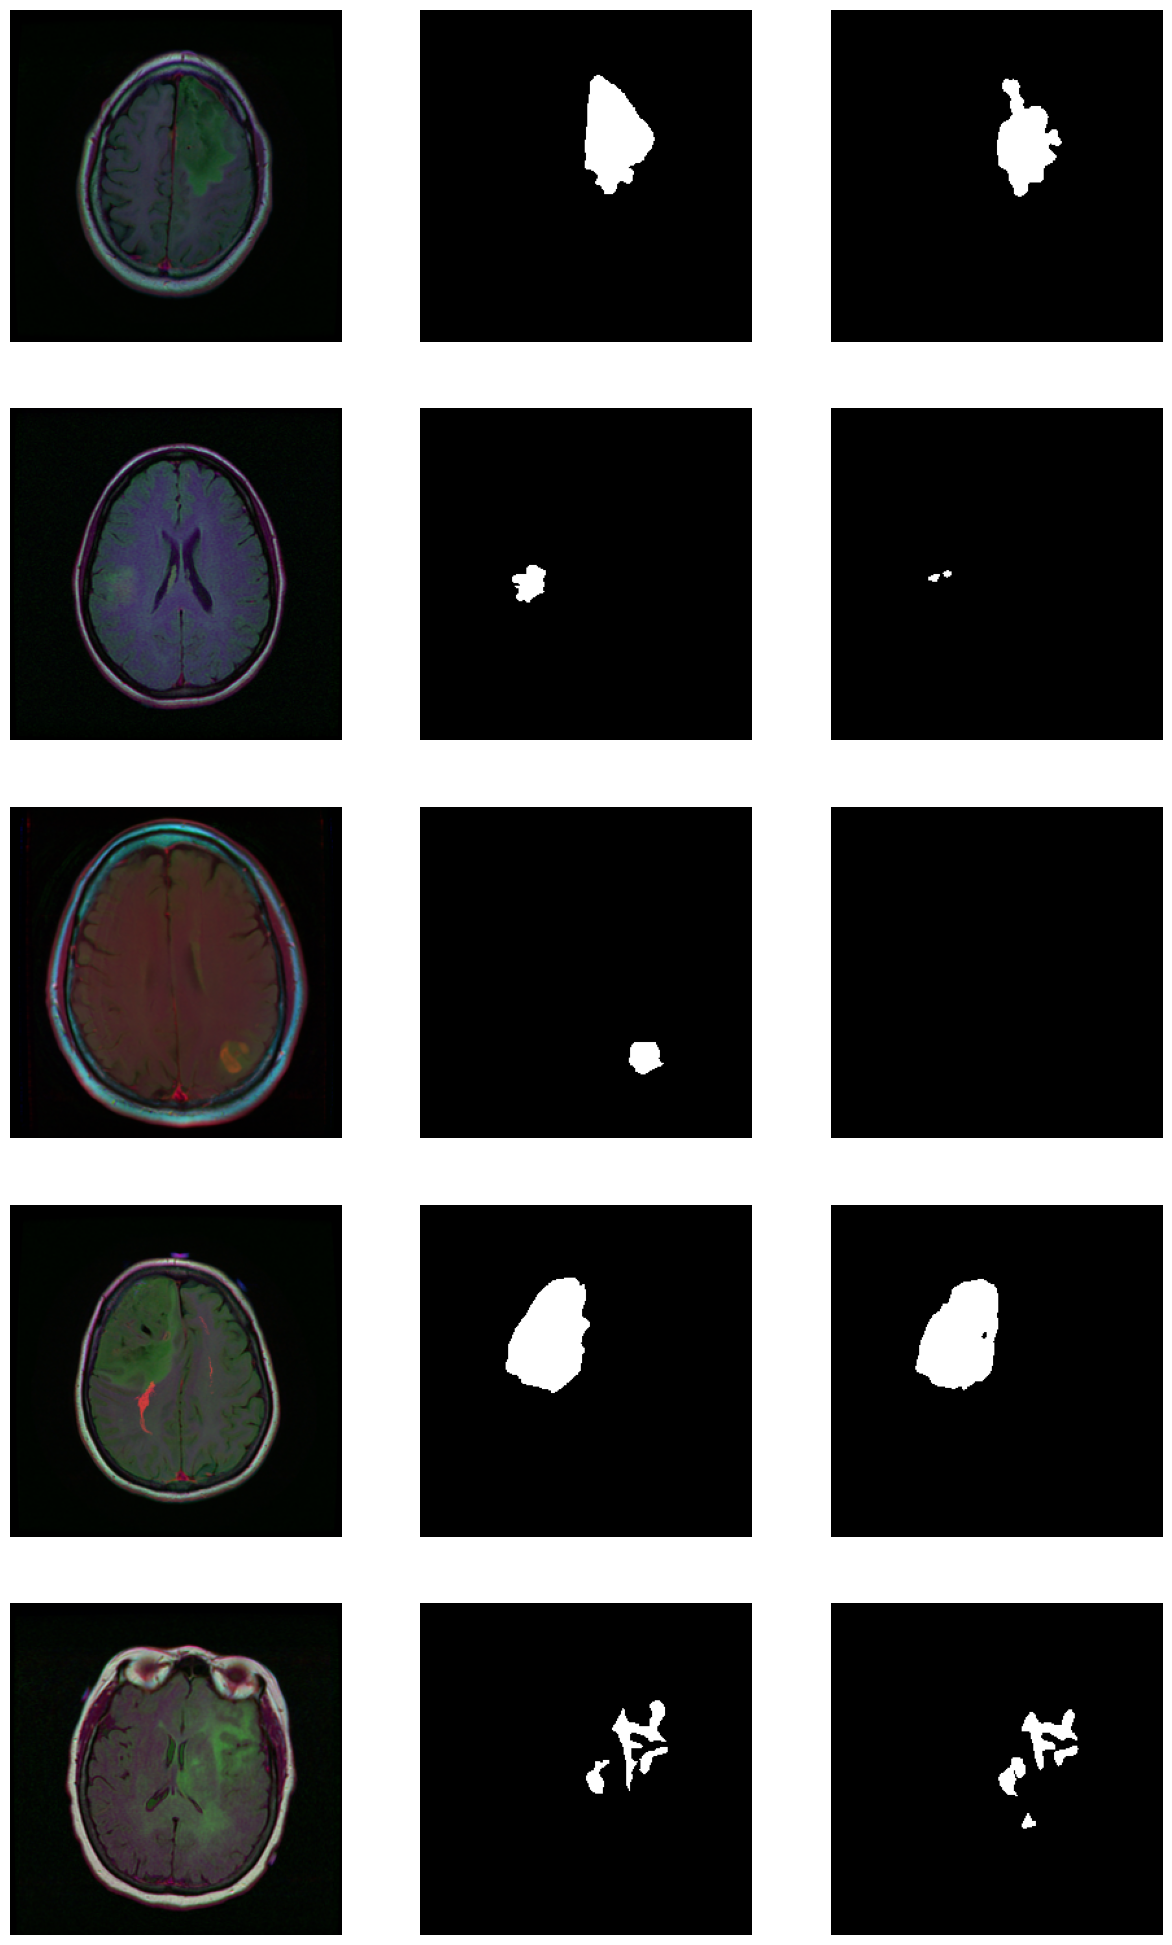

In [23]:


'''
    # Ensure enough samples exist in both categories
    tumor_indices = random.sample(tumor_indices, min(num_per_class, len(tumor_indices)))
    non_tumor_indices = random.sample(non_tumor_indices, min(num_per_class, len(non_tumor_indices)))

    selected_indices = tumor_indices + non_tumor_indices
    total_samples = len(selected_indices)

    plt.figure(figsize=(12, total_samples * 2.5))

    for i, idx in enumerate(selected_indices):
        image = X_test[idx]
        true_mask = y_test[idx]

        # Predict mask
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Titles
        label = "Tumor" if np.any(true_mask > 0) else "Non-Tumor"

        # Original MRI
        plt.subplot(total_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"{label} - MRI")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(total_samples, 3, i*3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        # Predicted mask
        plt.subplot(total_samples, 3, i*3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_predictions(model, X_test, y_test, num_per_class=4)
'''
selected_routes=brain_df_mask_test.sample(5)

plt.figure(figsize=(15,25))
for i in range(len(selected_routes)):

  plt.subplot(5,3,1+3*(i))
  image = cv2.cvtColor(io.imread(selected_routes.image_path.iloc[i]), cv2.COLOR_BGR2RGB)/255
  plt.imshow(image)
  plt.axis('off')

  plt.subplot(5,3,2+3*(i))
  true_mask = cv2.cvtColor(io.imread(selected_routes.mask_path.iloc[i]), cv2.COLOR_BGR2RGB)/255
  plt.imshow(true_mask)
  plt.axis('off')


  plt.subplot(5,3,3+3*(i))
  pred_mask=model_seg.predict(np.expand_dims(image, axis=0))[0]
  pred_mask = (pred_mask > 0.5).astype(np.uint8)
  plt.imshow(pred_mask, cmap='gray')
  plt.axis('off')


In [24]:
# Generate predictions for all test images
image_id = []
mask = []
has_mask = []

print("Generating predictions for test set...")
for i in range(len(brain_df_mask_test)):
    # Get image path
    img_path = brain_df_mask_test.image_path.iloc[i]

    # Read and preprocess image
    image = cv2.cvtColor(io.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0

    # Predict mask
    pred_mask = loaded_model_seg.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Store results
    image_id.append(img_path)
    mask.append(pred_mask)
    has_mask.append(1)  # All images in brain_df_mask_test have masks

    if (i + 1) % 20 == 0:
        print(f"Processed {i + 1}/{len(brain_df_mask_test)} images")

print(f"Completed! Generated predictions for {len(image_id)} images.")

Generating predictions for test set...
Processed 20/137 images
Processed 40/137 images
Processed 60/137 images
Processed 80/137 images
Processed 100/137 images
Processed 120/137 images
Completed! Generated predictions for 137 images.


In [25]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    ./data/TCGA_DU_7010_19860307/TCGA_DU_7010_1986...   
1    ./data/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1997...   
2    ./data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1997...   
3    ./data/TCGA_DU_7018_19911220/TCGA_DU_7018_1991...   
4    ./data/TCGA_DU_8168_19970503/TCGA_DU_8168_1997...   
..                                                 ...   
132  ./data/TCGA_HT_7884_19980913/TCGA_HT_7884_1998...   
133  ./data/TCGA_DU_5871_19941206/TCGA_DU_5871_1994...   
134  ./data/TCGA_HT_8107_19980708/TCGA_HT_8107_1998...   
135  ./data/TCGA_DU_7300_19910814/TCGA_DU_7300_1991...   
136  ./data/TCGA_HT_7860_19960513/TCGA_HT_7860_1996...   

                                        predicted_mask  has_mask  
0    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
1    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
2    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
3    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
4    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
..                                                 ...       ...  
132  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
133  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
134  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
135  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
136  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  

[137 rows x 3 columns]

In [26]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = brain_df_mask_test.merge(df_pred, on='image_path')
df_pred.head()

image_path  \
0  ./data/TCGA_DU_7010_19860307/TCGA_DU_7010_1986...   
1  ./data/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1997...   
2  ./data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1997...   
3  ./data/TCGA_DU_7018_19911220/TCGA_DU_7018_1991...   
4  ./data/TCGA_DU_8168_19970503/TCGA_DU_8168_1997...   

                                           mask_path  mask  \
0  ./data/TCGA_DU_7010_19860307/TCGA_DU_7010_1986...     1   
1  ./data/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1997...     1   
2  ./data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1997...     1   
3  ./data/TCGA_DU_7018_19911220/TCGA_DU_7018_1991...     1   
4  ./data/TCGA_DU_8168_19970503/TCGA_DU_8168_1997...     1   

                                      predicted_mask  has_mask  
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1

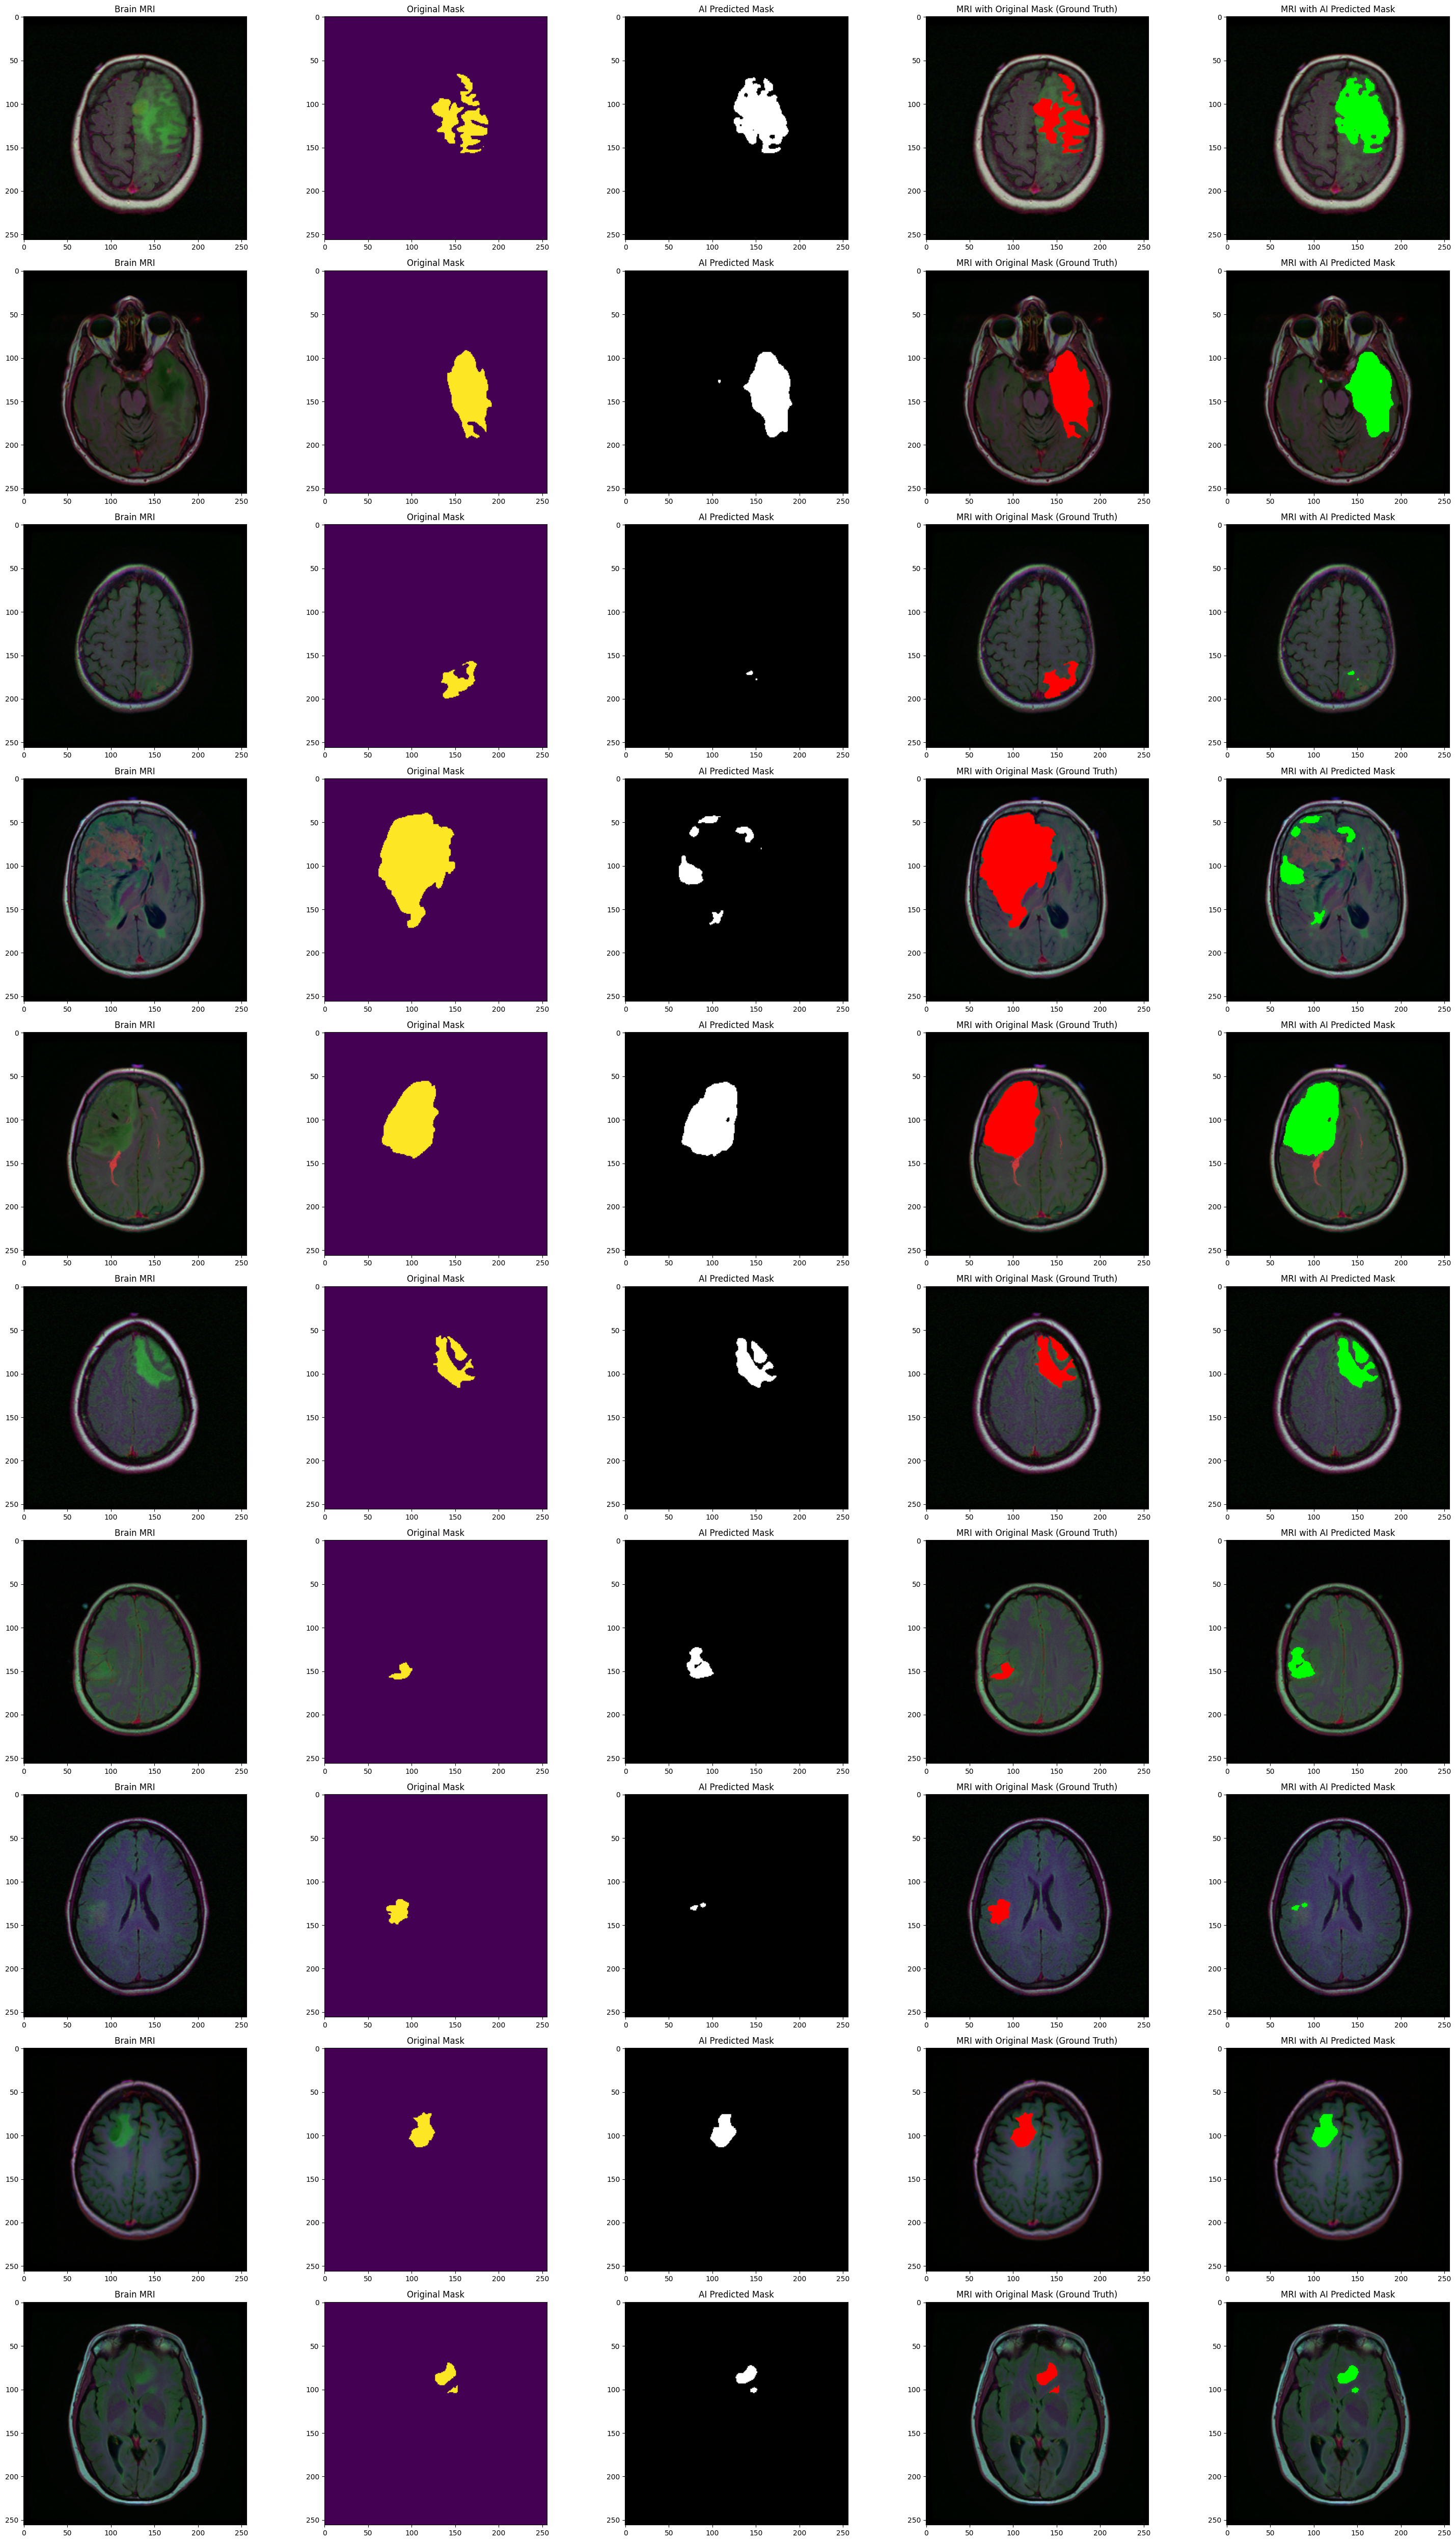

In [27]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image
    predicted_mask = np.array(df_pred.predicted_mask[i])
    # Ensure it's 2D (256, 256)
    if predicted_mask.ndim > 2:
        predicted_mask = predicted_mask.squeeze()
    if predicted_mask.ndim == 1:
        # If somehow flattened, reshape it
        predicted_mask = predicted_mask.reshape(256, 256)
    predicted_mask = predicted_mask.round().astype(np.uint8)
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask, cmap='gray')

    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

MINI CHALLENGE:
- Plot 30 images along with their corresponding mask
- Visually verify that model predictions made sense

# EXCELLENT JOB! NOW YOU KNOW HOW TO APPLY AI TO DETECT AND LOCALIZE BRAIN TUMORS. THIS IS A GREAT ACHIEVEMENT IN HEALTHCARE.

# MINI CHALLENGE SOLUTIONS

MINI CHALLENGE #1

In [28]:
# Obtain the number of images with mask
brain_df['mask'].value_counts()

mask
0    2533
1    1366
Name: count, dtype: int64

MINI CHALLENGE #2

In [ ]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

MINI CHALLENGE #3:

- An ensemble of these residual nets achieves 3.57% error
on the ImageNet test set.
- Solution (great article by Siddharth Das): https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

MINI CHALLENGE #4:
- Negative Transfer occurs when transfer learning negatively affect the model. This occurs when the features of old and new tasks are not related.  
- Transfer bounds: Measuring the amount of knowledge transfered is crucial to ensure model quality and robustness.

MINI CHALLENGE #5:

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# Total parameters (original model) = 25,685,634
# Total parameters (New model with added dense and dropout layers) = 25,751,426

MINI CHALLENGE #6:

In [ ]:

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

MINI CHALLENGE #7:


- Total params: 1,210,513

MINI CHALLENGE #8:

In [ ]:
count = 0
fig, axs = plt.subplots(30, 5, figsize=(60, 100))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 30:

# TASK #7: ASSESS TRAINED MODEL PERFORMANCE

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours)

model=load_model('./classifier-resnet-model6.keras')


In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

In [ ]:
test_predict.shape

In [ ]:
test_predict

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True,)

MINI CHALLENGE #6:
- Print out the classification report and comment on the precision, recall and F1-score results

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

# TRAINED MODEL TESTING

In [ ]:
# Load pretrained modeL

model=load_model('./classifier-resnet-model9.keras')


In [ ]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)
predict = predict.astype("object")

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

In [ ]:
# Obtain the accuracy of the model

print("accuracy_score: ", accuracy_score(original, predict))
print("f1_score: ", f1_score(original, predict,pos_label="1"))
print("precision_score: ", precision_score(original, predict,pos_label="1"))
print("recall_score: ", recall_score(original, predict,pos_label="1"))

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, fmt="d");

In [ ]:
original=original.astype("int")
predict=predict.astype("int")
RocCurveDisplay.from_predictions(original, predict);
